## 1. Loading necessary libraries

In [101]:
import pandas as pd
import numpy as np, warnings
from pathlib import Path
import os
import sweetviz as sv
from importlib import reload
import matplotlib.pyplot as plt
import seaborn as sns

np.warnings = warnings

In [310]:
import sys
sys.path.append("..")

# import utility functions
import src.utils as util
reload(util)

import src.load_parquet as load_parquet
reload(load_parquet)

# setup OS agnostic pathnames
ROOT_DIR = Path('..')

# Note: to run main notebook from root directory, use:
# ROOT_DIR = Path('')

import src.DataLoader as DataLoader
reload(DataLoader)

dataLoader = DataLoader.DataLoader(ROOT_DIR)

import nbimporter
import src.modelling_pipeline as modelling
reload(modelling)

<module 'src.modelling_pipeline' from '/Users/amyhung/Documents/CITS5553_project/data-science-capstone-project/Amy Hung/../src/modelling_pipeline.ipynb'>

In [103]:
# load libraries and modules
import pandas as pd
import numpy as np
import shap

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_validate, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_selection import SelectFromModel

# model comparison
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# evaluation metrics
from sklearn.metrics import cohen_kappa_score,classification_report 
from sklearn.metrics import mean_squared_error, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score, auc, make_scorer
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, balanced_accuracy_score
from sklearn.metrics import PrecisionRecallDisplay

## 2. Loading Data

In [104]:
df_desc_icd, df_desc_labitems, df_desc_items = dataLoader.load_descriptions()
df_diagnoses_icd = dataLoader.load_diagnoses_icd(df_desc_icd)
df_demographic = dataLoader.load_demographic(df_diagnoses_icd)
df_demographic = dataLoader.demographic_clean_AGE(df_demographic)
df_labevents = dataLoader.load_labevents(df_demographic)
df_labevents = dataLoader.labevents_compute_TIME(df_labevents, df_demographic)

Removed 8210 admissions with AGE < 18


## 3. Dataset Extraction

In [258]:
def extract_train_data(dataLoader, df_labevents, df_demographic, df_desc_labitems, hours, feature_filename, top_n_features, root_dir):
    for top_n in top_n_features:
        output_filename = root_dir / f'data/Model input data/t{hours}_top{top_n}_20231005.csv'
        dataLoader.extract_train_data_by_features(df_labevents, df_demographic, df_desc_labitems, hours=hours, feature_filename=feature_filename, feature_no=top_n, output_filename=output_filename)

In [ ]:
hours_list = [0, 1, 2, 3, 4]
top_n_features = [20, 30, 40, 50]

for hour in hours_list:
    extract_train_data(dataLoader, df_labevents, df_demographic, df_desc_labitems, hour, ROOT_DIR / 'data/labevents_comparison_sorted.csv', top_n_features, ROOT_DIR)


## 4. Data processing

### 4.1 Loading dataset

In [300]:
dfs_dict = modelling.get_dfs(ROOT_DIR, top_n_features, '20231005')

In [301]:
dfs_dict['top20']['t0']

,AGE,GENDER_NUM,IS_SEPSIS,ITEMID_50820,ITEMID_50821,ITEMID_50862,ITEMID_50882,ITEMID_50885,ITEMID_50893,ITEMID_50902,...,ITEMID_51222,ITEMID_51237,ITEMID_51244,ITEMID_51256,ITEMID_51265,ITEMID_51274,ITEMID_51275,ITEMID_51279,ITEMID_51301,SOFA
0,76,0,0,-999.0,-999.0,-999.0,25.0,-999.0,8.2,99.0,...,10.0,1.3,8.0,81.0,282.0,13.5,30.7,3.44,12.7,-999
1,47,1,0,-999.0,-999.0,-999.0,24.0,2.2,8.9,97.0,...,11.5,-999.0,6.9,89.6,207.0,-999.0,-999.0,3.80,9.7,4
2,41,0,0,-999.0,-999.0,-999.0,30.0,-999.0,-999.0,100.0,...,15.4,1.1,41.6,50.1,258.0,12.7,21.7,5.46,7.5,-999
3,50,1,0,-999.0,-999.0,-999.0,25.0,-999.0,-999.0,104.0,...,12.5,1.1,7.6,91.4,229.0,13.0,28.3,4.31,8.5,-999
4,72,0,0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,12.8,-999.0,-999.0,-999.0,339.0,-999.0,-999.0,4.15,7.7,-999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33807,77,0,0,-999.0,-999.0,-999.0,21.0,-999.0,9.0,105.0,...,12.6,1.1,17.0,77.4,185.0,12.5,25.8,4.17,11.0,-999
33808,65,1,0,-999.0,-999.0,-999.0,13.0,-999.0,-999.0,118.0,...,9.6,1.3,16.7,78.5,323.0,14.6,29.2,3.25,17.2,-999
33809,65,0,0,-999.0,-999.0,-999.0,34.0,-999.0,-999.0,94.0,...,11.2,2.4,15.0,77.9,145.0,24.8,40.0,3.48,6.1,-999
33810,53,0,1,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,12.4,-999.0,8.1,85.1,349.0,-999.0,-999.0,4.20,13.0,-999


In [297]:
dfs_dict['top30']['t0']

,AGE,GENDER_NUM,IS_SEPSIS,ITEMID_50804,ITEMID_50813,ITEMID_50818,ITEMID_50820,ITEMID_50821,ITEMID_50862,ITEMID_50878,...,ITEMID_51249,ITEMID_51256,ITEMID_51265,ITEMID_51274,ITEMID_51275,ITEMID_51277,ITEMID_51279,ITEMID_51301,ITEMID_51493,SOFA
0,76,0,0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,33.3,81.0,282.0,13.5,30.7,15.1,3.44,12.7,-999.0,-999
1,47,1,0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,69.0,...,33.8,89.6,207.0,-999.0,-999.0,13.6,3.80,9.7,-999.0,4
2,41,0,0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,34.1,50.1,258.0,12.7,21.7,13.4,5.46,7.5,-999.0,-999
3,50,1,0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,33.8,91.4,229.0,13.0,28.3,13.4,4.31,8.5,-999.0,-999
4,72,0,0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,33.4,-999.0,339.0,-999.0,-999.0,14.2,4.15,7.7,-999.0,-999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34860,77,0,0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,35.5,77.4,185.0,12.5,25.8,15.3,4.17,11.0,-999.0,-999
34861,65,1,0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,34.4,78.5,323.0,14.6,29.2,15.5,3.25,17.2,-999.0,-999
34862,65,0,0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,33.5,77.9,145.0,24.8,40.0,16.5,3.48,6.1,-999.0,-999
34863,53,0,1,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,34.2,85.1,349.0,-999.0,-999.0,14.0,4.20,13.0,-999.0,-999


### 4.2 Missing values

In [312]:
modelling.count_missing_values(dfs_dict['top20'])

Number of missing values in t0: 290110 (35.75%)
Number of missing values in t1: 313499 (33.30%)
Number of missing values in t2: 326948 (32.26%)
Number of missing values in t3: 331816 (31.22%)
Number of missing values in t4: 327054 (29.81%)


In [314]:
modelling.count_missing_values(dfs_dict['top30'])

Number of missing values in t0: 518408 (43.73%)
Number of missing values in t1: 525839 (38.98%)
Number of missing values in t2: 543831 (37.53%)
Number of missing values in t3: 549336 (36.19%)
Number of missing values in t4: 541247 (34.60%)


In [315]:
modelling.count_missing_values(dfs_dict['top40'])

Number of missing values in t0: 773131 (49.99%)
Number of missing values in t1: 791740 (45.17%)
Number of missing values in t2: 823611 (43.77%)
Number of missing values in t3: 836909 (42.48%)
Number of missing values in t4: 832047 (41.00%)


In [316]:
modelling.count_missing_values(dfs_dict['top50'])

Number of missing values in t0: 1022805 (54.70%)
Number of missing values in t1: 1051305 (49.72%)
Number of missing values in t2: 1100142 (48.48%)
Number of missing values in t3: 1124307 (47.33%)
Number of missing values in t4: 1125713 (46.01%)


In [317]:
modelling.count_missing_SOFA(dfs_dict['top20'])

Number of missing SOFA in t0: 22654 (67.00%)
Number of missing SOFA in t1: 25248 (64.36%)
Number of missing SOFA in t2: 26613 (63.03%)
Number of missing SOFA in t3: 27369 (61.79%)
Number of missing SOFA in t4: 27756 (60.72%)


In [318]:
modelling.count_missing_SOFA(dfs_dict['top30'])

Number of missing SOFA in t0: 23707 (68.00%)
Number of missing SOFA in t1: 25692 (64.76%)
Number of missing SOFA in t2: 27007 (63.37%)
Number of missing SOFA in t3: 27718 (62.09%)
Number of missing SOFA in t4: 28052 (60.98%)


### 4.3 Train/Test Split & Standardisation

In [113]:
X_t0_train, X_t0_test, y_t0_train, y_t0_test = modelling.split_data(t0_df)
X_t1_train, X_t1_test, y_t1_train, y_t1_test = modelling.split_data(t1_df)
X_t2_train, X_t2_test, y_t2_train, y_t2_test = modelling.split_data(t2_df)
X_t3_train, X_t3_test, y_t3_train, y_t3_test = modelling.split_data(t3_df)
X_t4_train, X_t4_test, y_t4_train, y_t4_test = modelling.split_data(t4_df)

### 4.4 Class weights

In [114]:
# Obtaining the class weights for model fitting
class_weights = modelling.get_class_weights(y_t0_train)
class_weights

{0: 1.1233, 1: 9.1135}

## 5. Model Fitting

In [161]:
# Initialise candidate models
candidate_models = {
    'Logistic_Regression': LogisticRegression(max_iter=10000000000, class_weight=class_weights, C=0.1, penalty=None, random_state=901),
    'Random_Forest': RandomForestClassifier(class_weight=class_weights, max_depth=7, min_samples_leaf=25, min_samples_split=250, random_state=901),
    'Gradient_Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=901)
    
    
    # 'SGD_Classifier': SGDClassifier(class_weight=class_weights),
    # 'XGB': XGBClassifier(),
    # 'KNeighbors': KNeighborsClassifier(),
    # 'Adaboost':AdaBoostClassifier()
    }

In [225]:
performance_df_t0 = modelling.static_models(candidate_models, class_weights, X_t0_train, y_t0_train, X_t0_test, y_t0_test, time = 't0')
performance_df_t1 = modelling.static_models(candidate_models, class_weights, X_t1_train, y_t1_train, X_t1_test, y_t1_test, time = 't1')
performance_df_t2 = modelling.static_models(candidate_models, class_weights, X_t2_train, y_t2_train, X_t2_test, y_t2_test, time = 't2')
performance_df_t3 = modelling.static_models(candidate_models, class_weights, X_t3_train, y_t3_train, X_t3_test, y_t3_test, time = 't3')
performance_df_t4 = modelling.static_models(candidate_models, class_weights, X_t4_train, y_t4_train, X_t4_test, y_t4_test, time = 't4')

Setting penalty=None will ignore the C and l1_ratio parameters
The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
Setting penalty=None will ignore the C and l1_ratio parameters
The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
Setting penalty=None will ignore the C and l1_ratio parameters
The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries bef

In [235]:
performance_df = pd.concat([performance_df_t0, performance_df_t1, performance_df_t2, performance_df_t3, performance_df_t4])
performance_df = performance_df.sort_values(by='Model')
performance_df.reset_index(drop=True, inplace=True)
performance_df

,Model,Balanced_Acc_Train,Balanced_Acc_Test,Precision_Train,Precision_Test,Recall_Train,Recall_Test,F1_Train,F1_Test
0,Gradient_Boosting_t0,0.564027,0.546627,0.693103,0.654867,0.135445,0.099730,0.226607,0.173099
1,Gradient_Boosting_t1,0.561572,0.547763,0.681548,0.553571,0.130820,0.106286,0.219506,0.178332
2,Gradient_Boosting_t2,0.564700,0.552067,0.675926,0.563158,0.137550,0.115178,0.228584,0.191242
3,Gradient_Boosting_t3,0.565570,0.544198,0.684143,0.516129,0.138961,0.099792,0.231002,0.167247
4,Gradient_Boosting_t4,0.561880,0.549768,0.677165,0.584699,0.131298,0.108850,0.219949,0.183533
5,Logistic_Regression_t0,0.657208,0.661513,0.189888,0.192263,0.663073,0.669811,0.295230,0.298768
6,Logistic_Regression_t1,0.660270,0.661743,0.189770,0.191307,0.690945,0.689143,0.297760,0.299479
7,Logistic_Regression_t2,0.668040,0.649969,0.194637,0.184950,0.687752,0.658773,0.303408,0.288815
8,Logistic_Regression_t3,0.667823,0.658057,0.193271,0.187737,0.683377,0.668399,0.301323,0.293139
9,Logistic_Regression_t4,0.670146,0.669553,0.194134,0.196014,0.680407,0.670397,0.302079,0.303337


# 6. Model Evaluation

Setting penalty=None will ignore the C and l1_ratio parameters


Logistic_Regression
 ---------------------------------------- 


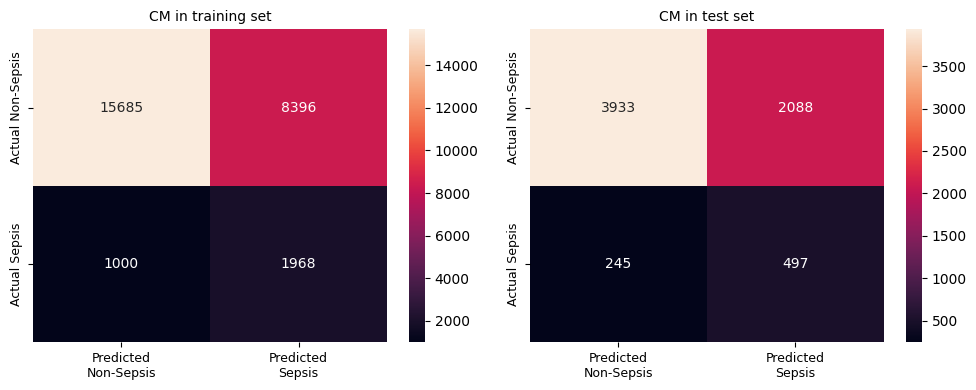

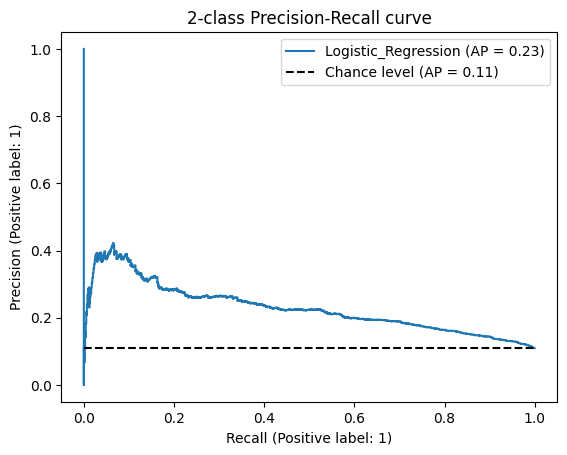

Logistic_Regression AUC : 0.7133


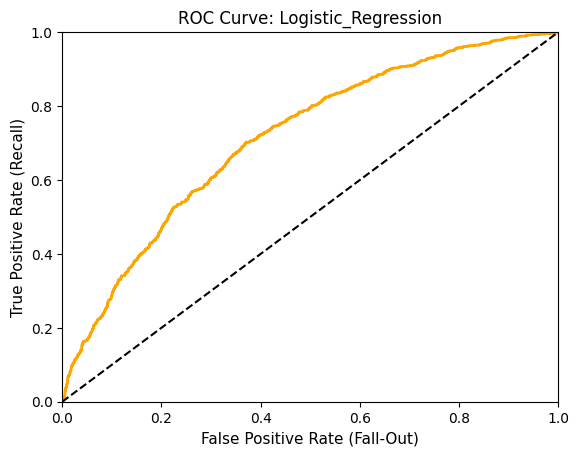

<Figure size 600x600 with 0 Axes>

Random_Forest
 ---------------------------------------- 


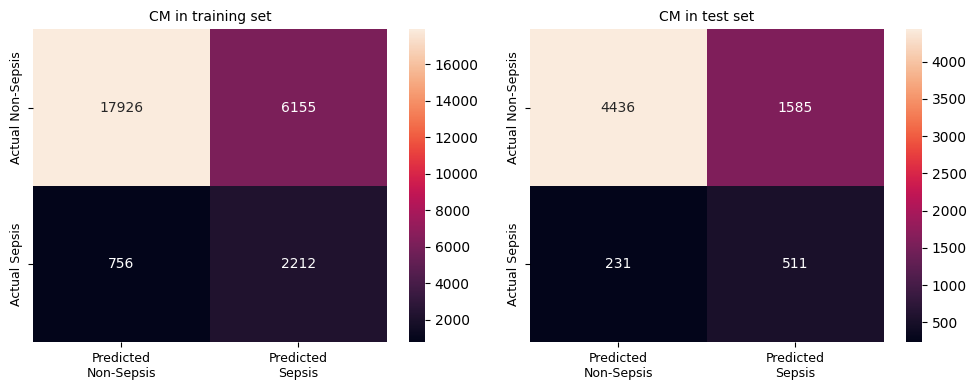

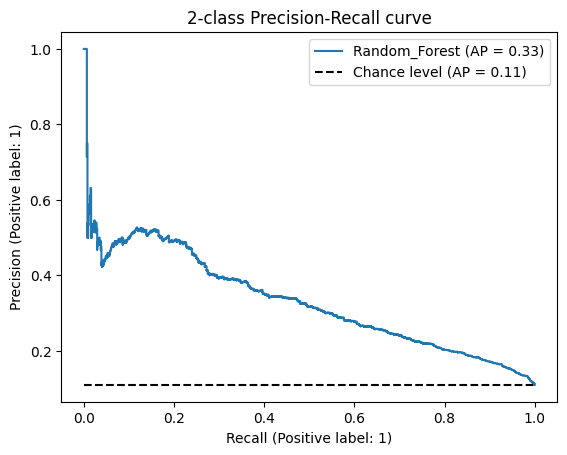

Random_Forest AUC : 0.7896


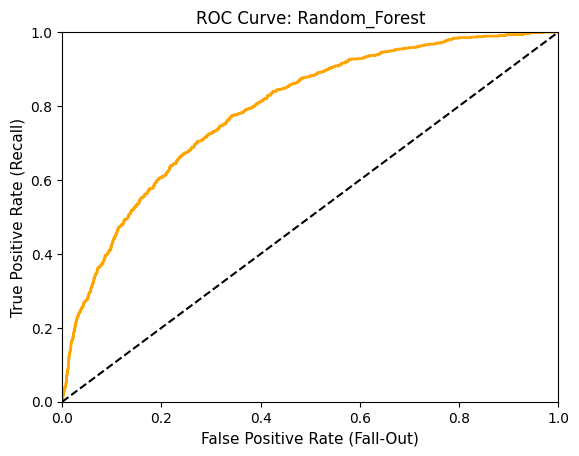

<Figure size 600x600 with 0 Axes>

Gradient_Boosting
 ---------------------------------------- 


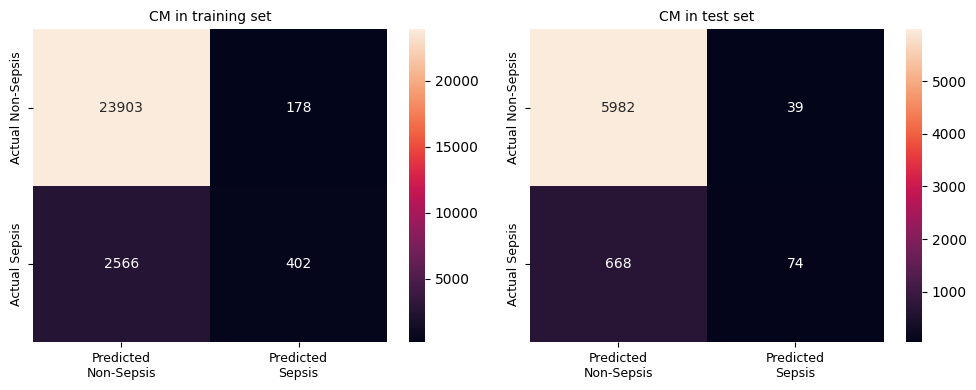

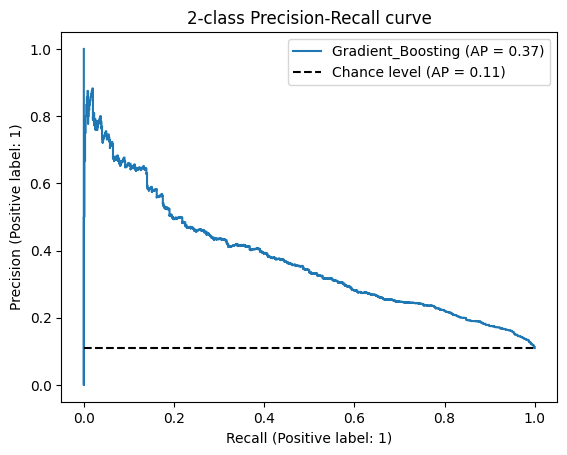

Gradient_Boosting AUC : 0.8028


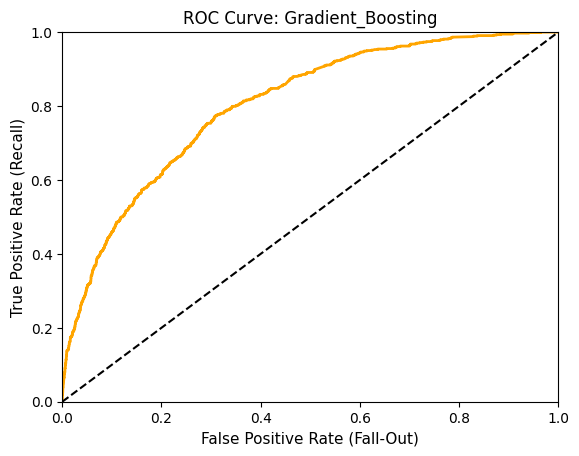

<Figure size 600x600 with 0 Axes>

In [204]:
modelling.plot_results(candidate_models, class_weights, X_t0_train, X_t0_test, y_t0_train, y_t0_test)

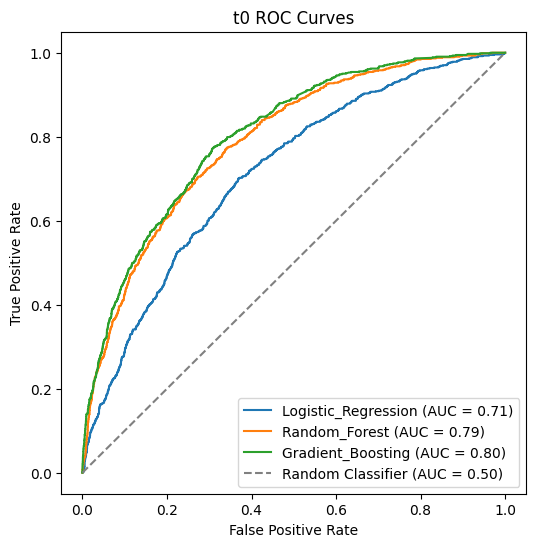

In [213]:
modelling.plot_combined_roc_curves(candidate_models, X_t0_test, y_t0_test, 't0 ROC Curves')